# Trees Etc.

In [6]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [4]:
# Importing train super-clean dataset
train = pd.read_csv('./data/train_superclean.csv')
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,OverallQualCategorical,storeyCount
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,None,None,0,2,2008,WD,Normal,208500,7,2.0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,None,None,0,5,2007,WD,Normal,181500,6,1.0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,None,None,0,9,2008,WD,Normal,223500,7,2.0


In [5]:
# Import libraries for building models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
#import lightgbm as lgb

In [21]:
# All done with one given random_key
train = pd.read_csv('./data/train_superclean.csv')
print(train.shape)
 # Drop categories that have poor representation in random sub-samples or that are not helpful (e.g. MiscFeature)
train = train.drop(['Heating', 'Electrical', 'Condition1', 'Condition2', 'MiscFeature', 'ExterCond', 
                    'Exterior1st', 'Exterior2nd', 'RoofMatl', 'Neighborhood', 'SaleType'], axis=1) 

train_with_dummies = pd.get_dummies(train)
train_train, train_test = train_test_split(train_with_dummies, test_size = 0.25, random_state = 5)
train_train_x = train_train.drop(['SalePrice'], axis=1)
train_train_y = train_train['SalePrice']
train_test_x = train_test.drop(['SalePrice'], axis=1)
train_test_y = train_test['SalePrice']
    
# apply best model to XGBRegressor
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 1000) 
grid_params = [{'max_depth': [5,10,15,20]}]
grid1 = bestModelFromGrid(model, grid_params, train_train_x, np.log(train_train_y))

(1460, 82)
Best RMSE: -0.14814717310085426
Best Parameters: {'max_depth': 5}
Average Time to Fit (sec): 5.167
Average Time to Score (sec): 0.024


TypeError: 'GridSearchCV' object is not iterable

In [61]:
def rmseSimple(model, X, y, isYLog=True):
    y_pred = model.predict(X)
    if(isYLog):
        rmse = np.sqrt(np.mean((y-y_pred)**2))
    else:
        rmse = np.sqrt(np.mean((np.log(y)-np.log(y_pred))**2))
    return(rmse)


from sklearn.metrics import make_scorer # insert RMSE as a custom scorer inside the rmseSimple
def rmseScore(y, y_pred, **kwargs):
    rmse = np.sqrt(np.mean((y-y_pred)**2))
    return(rmse)

rmseScorer = make_scorer(rmseScore, greater_is_better=False)    
def bestModelFromGrid(model, params, X, y):
    grid = GridSearchCV(model, params, scoring=rmseScorer, error_score = 0, return_train_score=True)
    grid.fit(X, y)
    print("Best RMSE: {0}".format(abs(grid.best_score_)) # Mean cross-validated score of the best_estimator
    print("Best Parameters: {0}".format(grid.best_params_))
    print("Average Time to Fit (sec): {0}".format(round(grid.cv_results_['mean_fit_time'].mean(),3)))
    print("Average Time to Score (sec): {0}".format(round(grid.cv_results_['mean_score_time'].mean(),3)))
    
    l1 = list(grid.param_grid[0].keys())
    paramName = l1[0] # assume we have only a one-parameter grid
    plt.figure(figsize=(10,7))
    cv_rmse = abs(grid.cv_results_['mean_train_score'])
    cv_std  = grid.cv_results_['std_train_score']
    train_y1  = cv_rmse - cv_std
    train_y2  = cv_rmse + cv_std
    print(train_y1)
    print(train_y2)
    plt.plot(param_range, cv_rmse, color='b')
    plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='b', alpha=0.1)

    cv_rmse = abs(grid.cv_results_['mean_test_score'])
    cv_std  = grid.cv_results_['std_test_score']
    test_y1  = cv_rmse - cv_std
    test_y2  = cv_rmse + cv_std
    plt.plot(param_range, cv_rmse, color='r')
    plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='r', alpha=0.1)

    plt.xlabel(paramName, fontsize=15)
    plt.ylabel('RMSE', fontsize=15)
    plt.title('Grid Search for {0}'.format(model.__class__.__name__))
    plt.legend(('Train','Validation'),loc='upper right')
    plt.show()   
    return(grid) # return the whole scored grid, we pick later what we need
    #return(grid.best_score_, grid.best_estimator_) # returns best model

SyntaxError: invalid syntax (<ipython-input-61-50de7e398032>, line 20)

Best RMSE: -0.15106057564114142
Best Parameters: {'n_estimators': 500}
Average Time to Fit (sec): 5.674
Average Time to Score (sec): 0.027
[ 0.09402872  0.00095842  0.00095842  0.00095842]
[ 0.09470634  0.00099426  0.00099426  0.00099426]


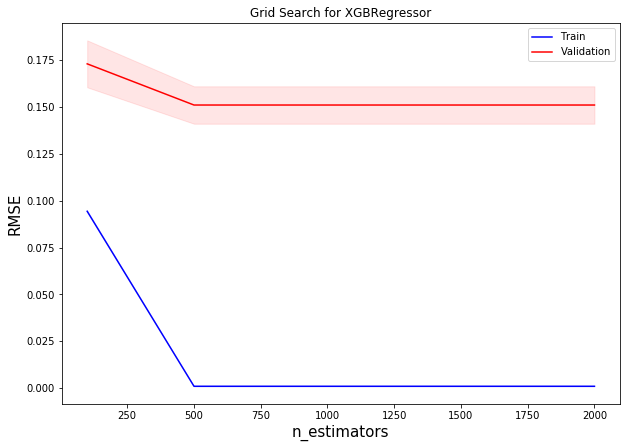

In [60]:
# XGBRegressor
model = XGBRegressor(n_estimators = 4000, max_depth=10, learning_rate = 0.05)
param_range = [100, 500, 1000, 2000]
grid1 = [{'n_estimators': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) # choose n_estimators = 500

Best RMSE: -0.15106057564114142
Best Parameters: {'learning_rate': 0.05}
Average Time to Fit (sec): 1.601
Average Time to Score (sec): 0.008
[  9.67944008e-01   1.01582257e-01   9.58416893e-04   8.93128931e-04
   4.24209358e-04]
[  9.68696263e-01   1.01854257e-01   9.94263845e-04   9.18347225e-04
   4.76731624e-04]


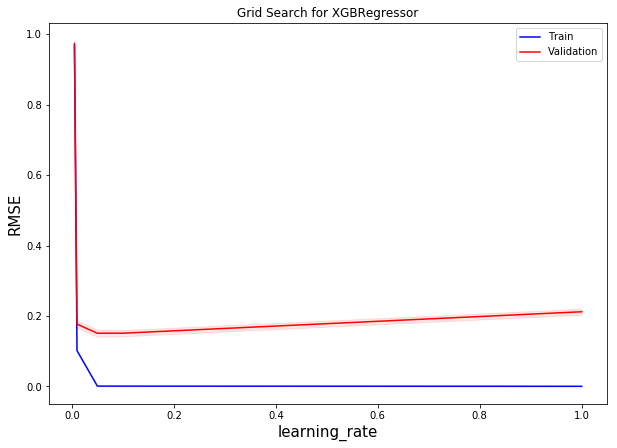

In [63]:
# XGBRegressor
model = XGBRegressor(n_estimators = 500, max_depth=10, learning_rate = 0.05)
param_range = [0.005, 0.01, 0.05, 0.1, 1]
grid1 = [{'learning_rate': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) # choose learning_rate = 0.01

Best RMSE: -0.17533654199054552
Best Parameters: {'max_depth': 5}
Average Time to Fit (sec): 57.383
Average Time to Score (sec): 0.012
[ 0.15209462  0.11361686  0.10158226  0.09963548]
[ 0.15478992  0.1161685   0.10185426  0.10021716]


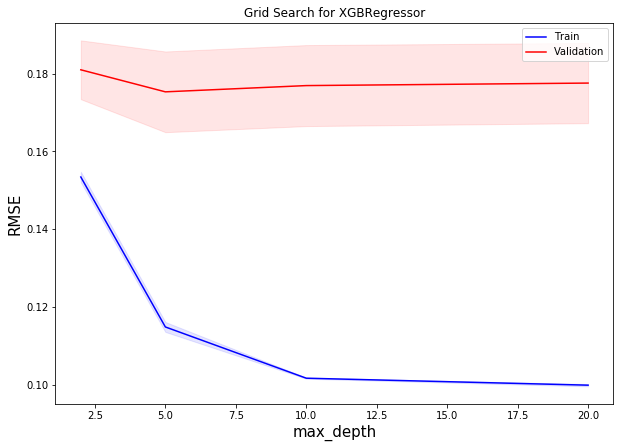

In [64]:
# XGBRegressor
model = XGBRegressor(n_estimators = 500, max_depth=5, learning_rate = 0.01) # chosen!!
param_range = [2, 5, 10, 20]
grid1 = [{'max_depth': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) # choose max_depth=5

Best RMSE: -0.15317338045530796
Best Parameters: {'n_estimators': 100}
Average Time to Fit (sec): 0.534
Average Time to Score (sec): 0.019
[ 0.05571082  0.0566099   0.05491825  0.05501263  0.05419093]
[ 0.05958835  0.05769461  0.05788434  0.05672548  0.05725145]


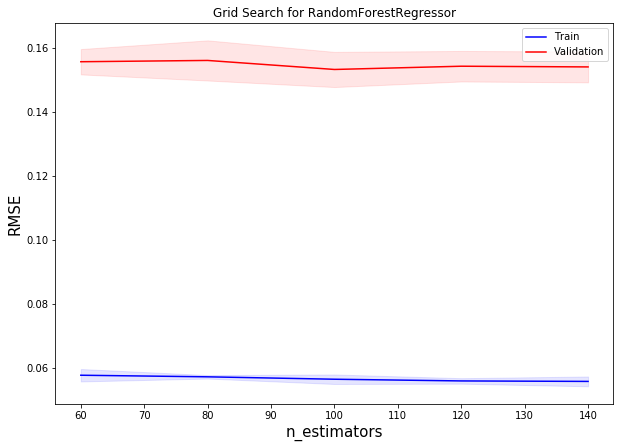

In [68]:
# RandomTree regressor
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators = 100, max_features=20, max_depth=300)
param_range = [60, 80, 100, 120, 140]
grid1 = [{'n_estimators': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) # choose n_estimators=100

Best RMSE: -0.1522733942264469
Best Parameters: {'max_features': 30}
Average Time to Fit (sec): 0.552
Average Time to Score (sec): 0.021
[ 0.05929432  0.0571448   0.05462236  0.05492359  0.05466536  0.05376552
  0.05635684]
[ 0.06307471  0.05877249  0.05951927  0.05729164  0.05632943  0.0569487
  0.05735006]


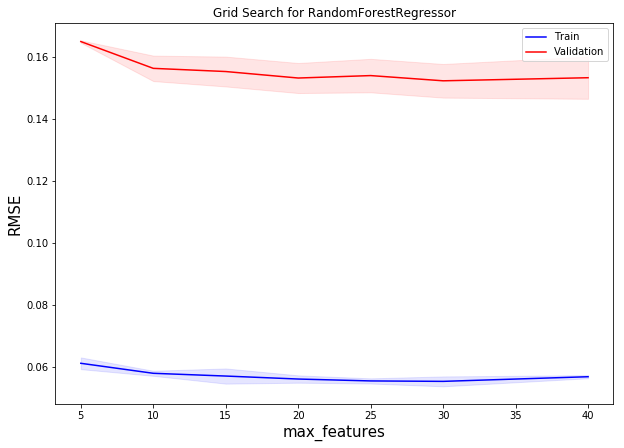

In [69]:
# RandomTree regressor
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators = 100, max_features=20, max_depth=300)
param_range = [5, 10, 15, 20, 25, 30, 40 ]
grid1 = [{'max_features': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) #choose max_features = 20

Best RMSE: -0.15328553121283145
Best Parameters: {'max_depth': 400}
Average Time to Fit (sec): 0.531
Average Time to Score (sec): 0.019
[ 0.05433577  0.05525054  0.05516106  0.05438398  0.05477891  0.05351177]
[ 0.05836356  0.05819191  0.05720806  0.05651747  0.05759437  0.05692971]


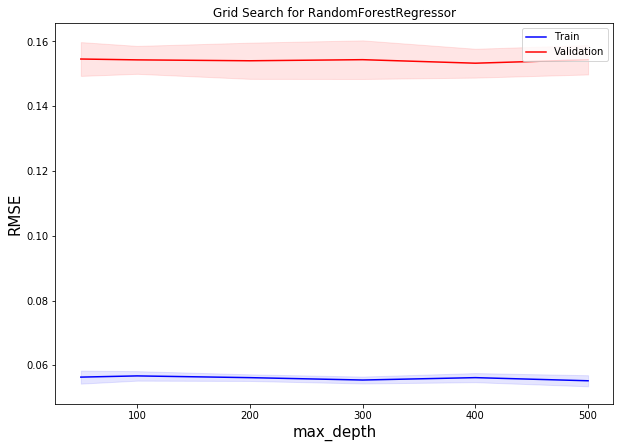

In [70]:
# RandomTree regressor
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators = 100, max_features=20, max_depth=100) # chosen!!
param_range = [ 50, 100, 200, 300, 400, 500 ]
grid1 = [{'max_depth': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) #choose max_depth=100

Best RMSE: -0.39705459291977535
Best Parameters: {'epsilon': 0}
Average Time to Fit (sec): 0.346
Average Time to Score (sec): 0.155
[ 0.00026418  0.00994828  0.03904735  0.09285355]
[ 0.00027468  0.00996194  0.03916525  0.09337491]


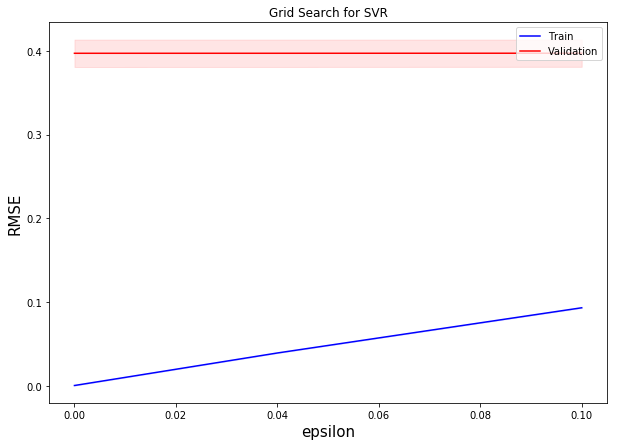

In [71]:
from sklearn.svm import SVR
model = SVR(epsilon = 0, C = 10) 
param_range = [ 0, 0.01, 0.04, 0.1 ]
grid1 = [{'epsilon': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) #choose epsilon=0

Best RMSE: -0.39704414606952493
Best Parameters: {'C': 1}
Average Time to Fit (sec): 0.36
Average Time to Score (sec): 0.167
[ 0.12704483  0.02928417  0.00026418  0.00026418  0.00026418  0.00026418]
[ 0.13250678  0.03323416  0.00027468  0.00027468  0.00027468  0.00027468]


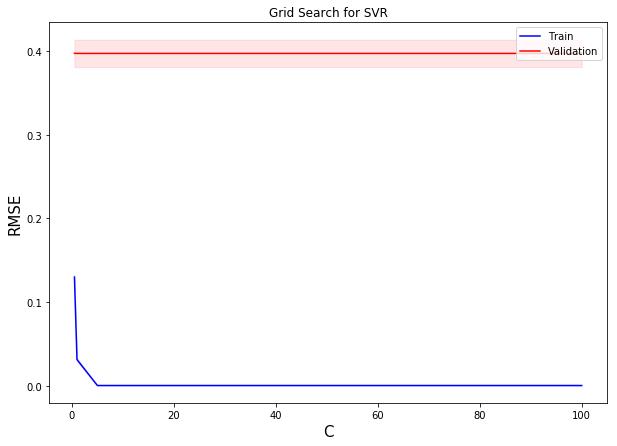

In [72]:
from sklearn.svm import SVR
model = SVR(epsilon = 0, C = 5) # chosen!! 
param_range = [ 0.5, 1, 5, 10, 20, 100 ]
grid1 = [{'C': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) #choose C = 5

Best RMSE: -0.1526447926588113
Best Parameters: {'n_estimators': 2000}
Average Time to Fit (sec): 15.04
Average Time to Score (sec): 0.027
[ 0.00798799  0.00129835  0.00031574  0.00031574]
[ 0.00962906  0.00181289  0.00031612  0.00031612]


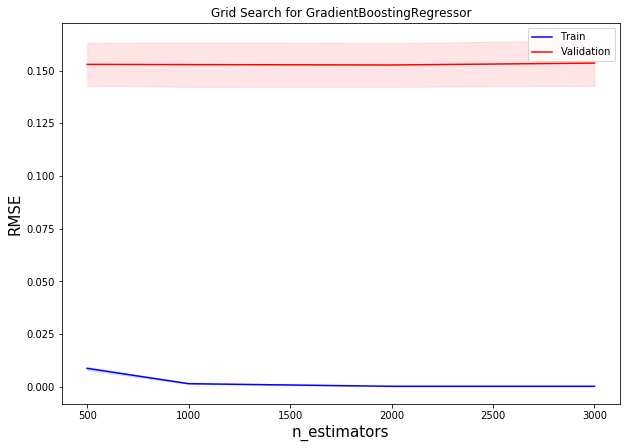

In [73]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators = 2000, max_depth = 5, learning_rate = 0.05) 
param_range = [ 500, 1000, 2000, 3000 ]
grid1 = [{'n_estimators': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) #choose 1000


Best RMSE: -0.1522838841037022
Best Parameters: {'max_depth': 5}
Average Time to Fit (sec): 159.893
Average Time to Score (sec): 0.008
[ 0.00129835  0.00031531  0.00031518  0.00031557  0.00031559]
[ 0.00181289  0.00031564  0.00031598  0.00031587  0.00031594]


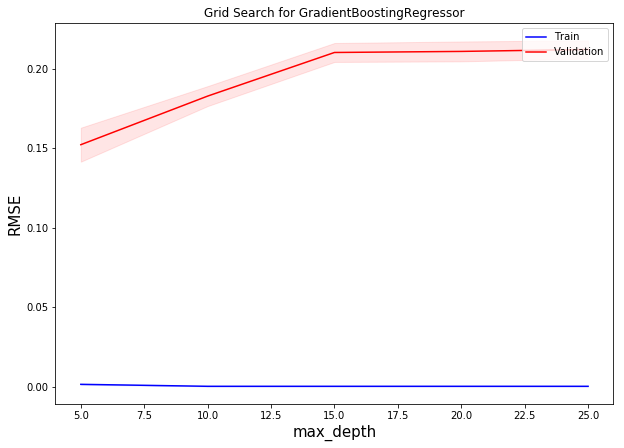

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators = 1000, max_depth = 5, learning_rate = 0.05) 
param_range = [ 5, 10, 15, 20, 25 ]
grid1 = [{'max_depth': param_range}]
grid1 = bestModelFromGrid(model, grid1, train_train_x, np.log(train_train_y)) #choose 1000

In [53]:
l1 = list(grid1.param_grid[0].keys())
print(type(l1[0]))

print('Grid Search for {0}'.format(model.__class__.__name__))

<class 'str'>
Grid Search for XGBRegressor


[ 0.09402872  0.00095842  0.00095842  0.00095842]
[ 0.09470634  0.00099426  0.00099426  0.00099426]


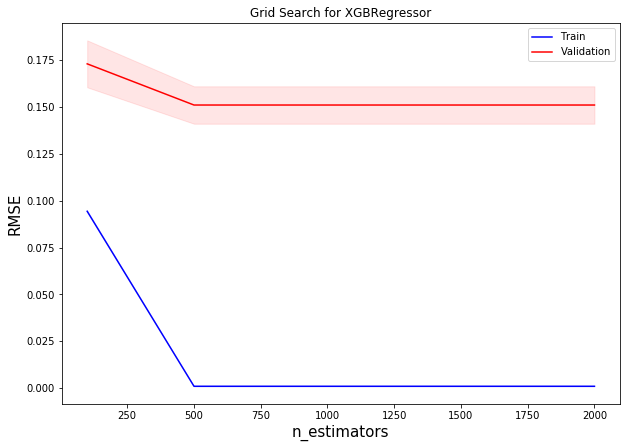

In [34]:
plt.figure(figsize=(10,7))

cv_rmse = abs(grid1.cv_results_['mean_train_score'])
cv_std  = grid1.cv_results_['std_train_score']
train_y1  = cv_rmse - cv_std
train_y2  = cv_rmse + cv_std
print(train_y1)
print(train_y2)
plt.plot(param_range, cv_rmse, color='b')
plt.fill_between(param_range, y1=train_y1, y2=train_y2, color='b', alpha=0.1)

cv_rmse = abs(grid1.cv_results_['mean_test_score'])
cv_std  = grid1.cv_results_['std_test_score']
test_y1  = cv_rmse - cv_std
test_y2  = cv_rmse + cv_std
plt.plot(param_range, cv_rmse, color='r')
plt.fill_between(param_range, y1=test_y1, y2=test_y2, color='r', alpha=0.1)

plt.xlabel('n_estimators', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.title('Grid Search for XGBRegressor')
plt.legend(('Train','Validation'),loc='upper right')
plt.show()


In [210]:
model = XGBRegressor(n_estimators = 1000, max_depth=5)
model.fit(train_train_x, np.log(train_train_y))
print(rmseSimple(model, train_train_x, np.log(train_train_y)))
print('Model1:', model)

model = XGBRegressor(n_estimators = 1000) 
grid_params = [{'max_depth': [5,10]}] # this is our grid, we vary one parameter at a time to generate train/test RMSE curves
_, bestModel = bestModelFromGrid(model, grid_params, train_train_x, np.log(train_train_y))
print(rmseSimple(bestModel, train_train_x, np.log(train_train_y)))
print('Model2:', bestModel)

0.0875605753021
0.00148780917843
Model1: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Best Accuracy: 0.8575409680566155
Best Parameters: {'max_depth': 5}
Average Time to Fit (sec): 5.454
Average Time to Score (sec): 0.026
0.00148780917843
Model2: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [211]:
print(bestModel)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [208]:
print(rmseSimple(bestModel, train_test_x, np.log(train_test_y)))

[ 12.3290329   12.15087032  12.16041565  11.34839344  11.76467705
  12.13510513  12.04557133  11.76478958  12.56037712  12.29734135
  11.77027607  12.01073742  12.44018173  11.50759983  11.95839024
  12.35531521  11.83180618  12.0306673   12.25577259  12.33385944
  12.21582127  12.44188499  11.75062561  12.30712605  12.43842888
  11.71383667  12.74230957  12.50081253  12.53494453  12.48517799
  12.46711445  12.10626888  11.70222092  11.79108334  11.54251575
  12.47199535  11.96569633  12.35040283  11.66342449  11.39094925
  12.33453655  11.82176971  11.85399914  12.46652317  11.9142971
  12.42088318  12.18988705  11.69680309  11.9260416   11.65941334
  13.02738476  12.17846107  12.09279919  11.34436607  12.27577019
  11.52314568  12.00649643  12.55989265  12.73123455  11.90143108
  11.71649361  12.49192238  12.19707012  12.72603893  11.91324234
  12.01998806  12.36933136  11.65576267  12.1511755   11.988307
  12.38099289  11.93191338  11.35431576  11.70448112  12.09936142
  11.8310442 

In [145]:
# apply best model to SVR
#from sklearn.svm import SVR
#model = SVR(epsilon=0, kernel='rbf')
#grid_params = [{'C': [1,5,10,20]}]
#bestModel = bestModelFromGrid(model, grid_params, train_train_x, train_train_y)
#print(bestModel.score(train_test_x, train_test_y)) # I am getting negative accuracy ??!!

Best Accuracy: 0.7919887976910931
Best Parameters: {'max_depth': 20}
Average Time to Fit (sec): 15.064
Average Time to Score (sec): 0.072


AttributeError: 'tuple' object has no attribute 'score'